# Classification - PyTorch

In [117]:
import torch
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device  = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
data = pd.read_csv('riceClassification.csv').drop('id', axis = 1)
original_data = data.copy()
print(data.shape)
data.head(3)

cpu
(18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1


In [118]:
## Verification target balanced
data.Class.value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

In [119]:
## Normalization 
for column in data.columns:
    data[column] = data[column] / data[column].abs().max()
data.head(3)

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.66661,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.53037,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.54638,0.856278,0.412994,0.959862,0.374747,1.0


In [120]:
X = np.array(data.iloc[:, : -1])   # (rows, columns)
y = np.array(data.iloc[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(12729, 10) (12729,)
(2728, 10) (2728,)
(2728, 10) (2728,)


In [121]:
class dataset(Dataset):
    def __init__(self, X, Y = None):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
train_data = dataset(X_train, y_train)
valid_data = dataset(X_valid, y_valid)
test_data = dataset(X_test, y_test)

train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
valid_dataloader = DataLoader(valid_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = False)

In [122]:
for x, y in train_dataloader:   # batch_size = 8
    print(x.shape)
    print(x)
    print('======')
    print(y.shape)
    print(y)
    break

torch.Size([32, 10])
tensor([[0.7916, 0.8313, 0.8305, 0.9236, 0.7463, 0.8897, 0.6460, 0.7141, 0.8512,
         0.5679],
        [0.7808, 0.7874, 0.8608, 0.9002, 0.7396, 0.8836, 0.6881, 0.6913, 0.8961,
         0.5190],
        [0.5885, 0.8458, 0.6082, 0.9786, 0.5571, 0.7672, 0.6085, 0.6648, 0.7303,
         0.7889],
        [0.9381, 0.9055, 0.8987, 0.9252, 0.8912, 0.9686, 0.8285, 0.7795, 0.8468,
         0.5717],
        [0.9731, 0.9052, 0.9308, 0.9166, 0.9201, 0.9864, 0.6592, 0.7931, 0.8485,
         0.5517],
        [0.5599, 0.7860, 0.6326, 0.9640, 0.5441, 0.7483, 0.6872, 0.6604, 0.7041,
         0.7050],
        [0.5929, 0.7872, 0.6557, 0.9588, 0.5620, 0.7700, 0.5908, 0.6423, 0.7880,
         0.6812],
        [0.8849, 0.8790, 0.8739, 0.9248, 0.8354, 0.9407, 0.7509, 0.7558, 0.8496,
         0.5707],
        [0.5524, 0.8001, 0.6028, 0.9730, 0.5277, 0.7432, 0.9140, 0.6445, 0.7293,
         0.7531],
        [0.6498, 0.8889, 0.6398, 0.9785, 0.6149, 0.8061, 0.5114, 0.7113, 0.7043,
       

In [123]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input = nn.Linear(in_features = X.shape[1], out_features = HIDDEN_NEURONS * 2)
        self.linear = nn.Linear(in_features = HIDDEN_NEURONS * 2, out_features = HIDDEN_NEURONS)
        self.linear2 = nn.Linear(in_features = HIDDEN_NEURONS, out_features = 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.linear(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x
    
model = MyModel().to(device)  # Only configure the model to device
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             220
            Linear-2                   [-1, 10]             210
            Linear-3                    [-1, 1]              11
           Sigmoid-4                    [-1, 1]               0
Total params: 441
Trainable params: 441
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
# Classification binaire (0 ou 1), format flottant, Probabilités entre 0 et 1 (avec sigmoid), Acc = round() sur probabilités (sigmoid)
criterion = nn.BCELoss()  
optimizer = Adam(model.parameters(), lr=0.001)

total_loss_train = []
total_loss_valid = []
total_accuracy_train = []
total_accuracy_valid = []

epochs = 50
for epoch in range(epochs):
    accuracy_train = 0
    accuracy_valid = 0
    loss_train = 0
    loss_valid = 0

    # Entraînement
    for data in train_dataloader:
        inputs, labels = data
        prediction = model(inputs)
        batch_loss = criterion(prediction, labels.view(-1, 1))
        loss_train += batch_loss.item()

        acc = (prediction.round() == labels.view(-1, 1)).sum().item()
        accuracy_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    with torch.no_grad():
        for data in valid_dataloader:
            inputs, labels = data
            predictions = model(inputs)
            batch_loss = criterion(predictions, labels.view(-1, 1))
            loss_valid += batch_loss.item()

            acc = (predictions.round() == labels.view(-1, 1)).sum().item()
            accuracy_valid += acc

    total_loss_train.append(loss_train / len(train_dataloader))
    total_loss_valid.append(loss_valid / len(valid_dataloader))
    total_accuracy_train.append(accuracy_train / len(train_dataloader.dataset))
    total_accuracy_valid.append(accuracy_valid / len(valid_dataloader.dataset))

    print(f'Epoch: {epoch + 1}/{epochs}')
    print(f'Train Loss: {total_loss_train[-1]:.4f}')
    print(f'Valid Loss: {total_loss_valid[-1]:.4f}')
    print(f'Train Accuracy: {total_accuracy_train[-1]:.4f}')
    print(f'Valid Accuracy: {total_accuracy_valid[-1]:.4f}')
    print('========================')

Epoch: 1/50
Train Loss: 0.4325
Valid Loss: 0.0885
Train Accuracy: 0.8463
Valid Accuracy: 0.9853
Epoch: 2/50
Train Loss: 0.0623
Valid Loss: 0.0485
Train Accuracy: 0.9840
Valid Accuracy: 0.9861
Epoch: 3/50
Train Loss: 0.0474
Valid Loss: 0.0523
Train Accuracy: 0.9846
Valid Accuracy: 0.9817
Epoch: 4/50
Train Loss: 0.0453
Valid Loss: 0.0450
Train Accuracy: 0.9852
Valid Accuracy: 0.9861
Epoch: 5/50
Train Loss: 0.0442
Valid Loss: 0.0460
Train Accuracy: 0.9849
Valid Accuracy: 0.9835
Epoch: 6/50
Train Loss: 0.0441
Valid Loss: 0.0458
Train Accuracy: 0.9842
Valid Accuracy: 0.9839
Epoch: 7/50
Train Loss: 0.0434
Valid Loss: 0.0459
Train Accuracy: 0.9855
Valid Accuracy: 0.9839
Epoch: 8/50
Train Loss: 0.0430
Valid Loss: 0.0443
Train Accuracy: 0.9844
Valid Accuracy: 0.9864
Epoch: 9/50
Train Loss: 0.0442
Valid Loss: 0.0475
Train Accuracy: 0.9842
Valid Accuracy: 0.9831
Epoch: 10/50
Train Loss: 0.0437
Valid Loss: 0.0462
Train Accuracy: 0.9844
Valid Accuracy: 0.9842
Epoch: 11/50
Train Loss: 0.0431
Valid L

In [125]:
with torch.no_grad():
    loss_test = 0
    accuracy_test = 0
    for data in test_dataloader:
        inputs, labels = data
        predictions = model(inputs)
        batch_loss = criterion(predictions, labels.view(-1, 1))

        loss_test += batch_loss.item()
        acc = (predictions.round() == labels.view(-1, 1)).sum().item()
        accuracy_test += acc

print(f'Accuracy: {accuracy_test / test_data.__len__():4}')

Accuracy: 0.9915689149560117


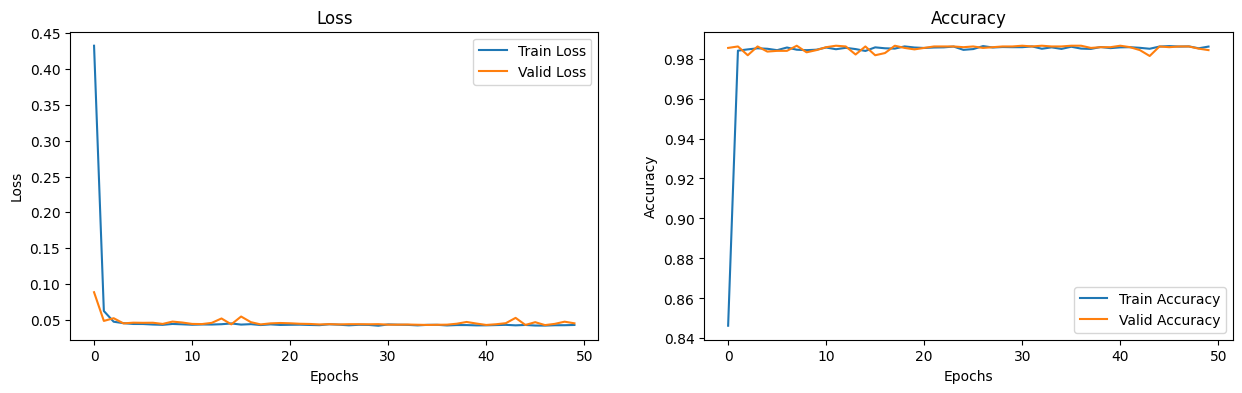

In [126]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(total_loss_train, label='Train Loss')
plt.plot(total_loss_valid, label='Valid Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(total_accuracy_train, label='Train Accuracy')
plt.plot(total_accuracy_valid, label='Valid Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Inference 

In [128]:
sample_rice_data = {
    'Area': 2345.6,
    'MajorAxisLength': 75.3,
    'MinorAxisLength': 31.8,
    'Eccentricity': 0.87,
    'ConvexArea': 2401.2,
    'EquivDiameter': 54.6,
    'Extent': 0.79,
    'Perimeter': 188.4,
    'Roundness': 0.69,
    'AspectRation': 2.37
}
sample_rice_data = pd.DataFrame(sample_rice_data, index = [0])
for columns in sample_rice_data.columns:
    sample_rice_data[columns] = sample_rice_data[columns] / original_data[columns].abs().max()

sample_rice_data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation
0,0.229736,0.411001,0.385218,0.8999,0.218132,0.478878,0.891072,0.370493,0.762643,0.605852


In [145]:
torch_data = torch.tensor(np.array(sample_rice_data), dtype = torch.float32).to(device)
prediction = model(torch_data)
prediction

tensor([[1.0000]], grad_fn=<SigmoidBackward0>)